***Final Project Notebook***

In [35]:
import matplotlib.pyplot as plt
# plt.style.use('classic')

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go 
lab_data = pd.read_csv("1 Laboratory Failure-Time and Single-Time Strength Data/ApplianceB.csv")
lab_data


,Data Source,Censoring Indicator,Count,Days,Failure Mode
0,Field,Failed,1,181,Wear
1,Field,Censored,1,95,Censored
2,Field,Censored,1,504,Censored
3,Field,Censored,1,588,Censored
4,Field,Censored,1,386,Censored
...,...,...,...,...,...
393,CrackTest,Failed,1,458,Cracked
394,CrackTest,Failed,1,483,Cracked
395,CrackTest,Failed,1,323,Cracked
396,CrackTest,Failed,1,482,Cracked


In [3]:
field_data = pd.read_csv("2 Field Failure-time Data/ApplianceBField.csv")
field_data

,Data Source,Censoring Indicator,Count,Days,Failure Mode
0,Field,Failed,1,181,Wear
1,Field,Censored,1,95,Censored
2,Field,Censored,1,504,Censored
3,Field,Censored,1,588,Censored
4,Field,Censored,1,386,Censored
...,...,...,...,...,...
364,Field,Censored,8,14,Censored
365,Field,Censored,38,12,Censored
366,Field,Censored,16,10,Censored
367,Field,Censored,1,9,Censored


**Compare the two Datasets here**


In [75]:
lab_data['Data Source'].value_counts()
lab_data_failed = lab_data[lab_data["Censoring Indicator"] == 'Failed']
lab_data["Censoring Indicator"].value_counts()

Censored    257
Failed      141
Name: Censoring Indicator, dtype: int64

In [10]:
lab_data_failed["Failure Mode"].value_counts()

Wear       101
Cracked     40
Name: Failure Mode, dtype: int64

In [14]:
lab_data_failed[lab_data_failed["Days"]==687]

,Data Source,Censoring Indicator,Count,Days,Failure Mode
372,WearTest,Failed,1,687,Wear


In [20]:
total_lab_appliance=lab_data.Count.sum()
total_lab_app_failure = lab_data_failed.Count.sum()
total_lab_app_failure

141

In [34]:
table1 = [["Not Failed", total_lab_appliance-total_lab_app_failure],["Failed", total_lab_app_failure]]
test = pd.DataFrame(table1, columns=["Failed or Not", "Count"])
test

,Failed or Not,Count
0,Not Failed,4617
1,Failed,141


In [58]:
test2 = test.copy()
test2.Count = (test2["Count"]/test2["Count"].sum())
test2
fig1 = px.bar(test2, x=test["Failed or Not"], y="Count", width=800, height=400,
    labels=dict(x="Appliance Status", color="Place"),
    )
fig1.update_layout(
    title="Appliance Status from Lab Study",
    xaxis_title="Appliance Status",
    yaxis_title="Unit Count %",
    font=dict(
        size=18
    )
)
fig1.show()

Lab results for the appliance failure rate over the study period.  In the end, only about **3%** of the units studied failed during accelerated degredation lab tests.  We will compare this along with the types of failures and counts of each type later in the notebook with the data collected from the field.

In [94]:
#take the failed rows and divide their count by the days it took for a failure.
array1 = lab_data_failed['Count']/(lab_data_failed['Days']/365)
lab_data_failed['Failures Per Year'] = array1
lab_data_failed['Wear FPY'] =   lab_data_failed[lab_data_failed["Failure Mode"]=="Wear"]["Failures Per Year"]
lab_data_failed['Cracked FPY'] = lab_data_failed[lab_data_failed["Failure Mode"]=="Cracked"]['Failures Per Year'] 
lab_data_failed = lab_data_failed.fillna(0)
lab_data_failed.head()

,Data Source,Censoring Indicator,Count,Days,Failure Mode,Failures Per Year,Wear FPY,Cracked FPY
0,Field,Failed,1,181,Wear,2.016575,2.016575,0.0
6,Field,Failed,1,278,Wear,1.312950,1.312950,0.0
9,Field,Failed,1,493,Wear,0.740365,0.740365,0.0
10,Field,Failed,1,223,Wear,1.636771,1.636771,0.0
12,Field,Failed,1,269,Wear,1.356877,1.356877,0.0


In [98]:
#Sum up two failure per year types
lab_fpy = pd.pivot_table(data = lab_data_failed, values=['Wear FPY', 'Cracked FPY'], index='Failure Mode', aggfunc=np.sum)
lab_fpy

,Cracked FPY,Wear FPY
Failure Mode,,
Cracked,52.757344,0.000000
Wear,0.000000,164.601821


The above shows the failures per year of Appliance B found in the Lab Failure studies.  Below we will create a linear regression model for the lab data.

In [124]:

from sklearn.linear_model import LinearRegression
lab_data_failed["Days"].value_counts()
#create scatter plot with days on x axis and number of failures on y axis, may need to combine repeated days because
#first create a new dataframe with just the days, count, and failures per year
fail_df_new = lab_data_failed[["Days","Count", "Failures Per Year"]].copy()
fail_df_new

,Days,Count,Failures Per Year
0,181,1,2.016575
6,278,1,1.312950
9,493,1,0.740365
10,223,1,1.636771
12,269,1,1.356877
...,...,...,...
393,458,1,0.796943
394,483,1,0.755694
395,323,1,1.130031
396,482,1,0.757261


In [125]:
fail_df_new = fail_df_new.groupby(fail_df_new.Days).sum()


In [135]:
fail_df_new.index.values

fail_df_new["Total Fails so far"] = fail_df_new["Count"].cumsum(axis=0)
fail_df_new

,Count,Failures Per Year,Total Fails,Total Fails so far
Days,,,,
53,1,6.886792,1,1
61,1,5.983607,2,2
68,1,5.367647,3,3
72,1,5.069444,4,4
76,1,4.802632,5,5
...,...,...,...,...
583,1,0.626072,137,137
588,1,0.620748,138,138
602,1,0.606312,139,139


From the above, we have a cummulative count of the number of the appliance failures as the days index increases.  Now we will normalize the values compared to the total appliance counts that were in the tests to give a percentage of the failed appliances over time.

In [145]:
test["Count"].sum() #total number of appliances in the lab tests
#add new column for percentages
fail_df_new["Cummulative Porportion of failed devices"] = fail_df_new["Total Fails so far"]/(test["Count"].sum())
fail_df_new["Days"] = fail_df_new.index
fail_df_new

,Count,Failures Per Year,Total Fails,Total Fails so far,Cummulative Porportion of failed devices,Days
Days,,,,,,
53,1,6.886792,1,1,0.000210,53
61,1,5.983607,2,2,0.000420,61
68,1,5.367647,3,3,0.000631,68
72,1,5.069444,4,4,0.000841,72
76,1,4.802632,5,5,0.001051,76
...,...,...,...,...,...,...
583,1,0.626072,137,137,0.028794,583
588,1,0.620748,138,138,0.029004,588
602,1,0.606312,139,139,0.029214,602


The last table value matches what we found prevously in the bar chart, proving the accuracy of my calculated column

<AxesSubplot: xlabel='Days', ylabel='Cummulative Porportion of failed devices'>

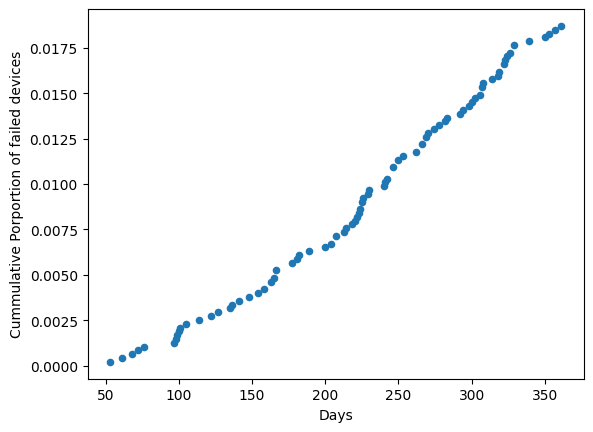

In [144]:
fail_df_new_train = fail_df_new.loc[:365].copy()
fail_df_new_test = fail_df_new.loc[365:].copy()
fail_df_new_train.plot.scatter(x="Days", y="Cummulative Porportion of failed devices")

In [146]:
from sklearn.linear_model import LinearRegression

X_train = fail_df_new_train[["Days"]]
X_test = fail_df_new_test[["Days"]]
y_train = fail_df_new_train["Cummulative Porportion of failed devices"]

model = LinearRegression()
model.fit(X=X_train, y=y_train)
model.predict(X=X_test)

array([0.01878463, 0.01924532, 0.01970601, 0.0201667 , 0.02023251,
       0.02062739, 0.02115389, 0.02187783, 0.02214108, 0.02233852,
       0.02279921, 0.02293083, 0.02319408, 0.02437871, 0.0248394 ,
       0.02490521, 0.02497102, 0.02510265, 0.02523427, 0.02543171,
       0.02569496, 0.0258924 , 0.0264189 , 0.02648471, 0.02714284,
       0.02766934, 0.02786678, 0.02826166, 0.02839328, 0.02911722,
       0.02924885, 0.03036766, 0.03221042, 0.03253948, 0.03306598,
       0.03339504, 0.03431642, 0.0368173 , 0.0399105 ])

<AxesSubplot: xlabel='Days', ylabel='Cummulative Porportion of failed devices'>

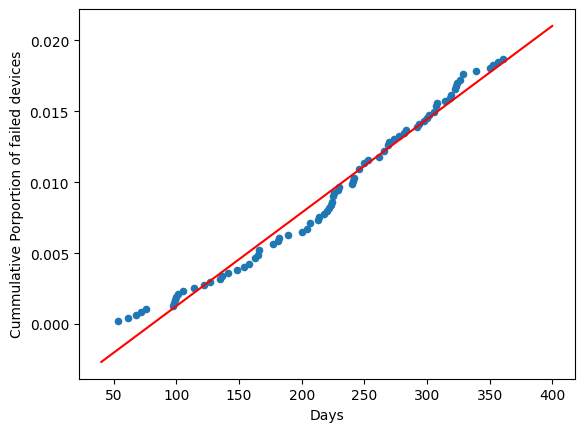

In [150]:
import numpy as np

X_new = pd.DataFrame()
# create a sequence of 200 evenly spaced numbers from 10 to 41
X_new["Days"] = np.linspace(40, 400, num=200)

# create a Series out of the predicted values
# (trailing underscore indicates fitted values)
y_new_ = pd.Series(
    model.predict(X_new), # y values in Series.plot.line()
    index=X_new["Days"]    # x values in Series.plot.line()
)

# plot the data, then the model
fail_df_new_train.plot.scatter(x="Days", y="Cummulative Porportion of failed devices")
y_new_.plot.line(color='red')

Grab Backblaze data and compare it to manufacturer wear statements


In [106]:
bblaze_data_1 = pd.read_csv("2 Field Failure-Time Data/Backblaze1Q2016.csv")
bblaze_data_1_failed = bblaze_data_1[bblaze_data_1["Censored"] != True]
bblaze_data_1

,Serial Number,Model,Start Date,End Date,Hours Lower,Hours Upper,Failed,Censored,Drive Model Name
0,13H2B97AS,35,10/15/2013,3/31/2016,1349,18433,0,True,TOSHIBA DT01ACA300
1,13H3012AS,35,10/15/2013,9/8/2014,1256,9122,0,True,TOSHIBA DT01ACA300
2,13H32WEAS,35,4/26/2013,3/31/2016,8,25684,0,True,TOSHIBA DT01ACA300
3,13H6A0DGS,35,4/20/2013,9/2/2014,13,12006,0,True,TOSHIBA DT01ACA300
4,13H6A21GS,35,5/22/2013,3/31/2016,14,25050,0,True,TOSHIBA DT01ACA300
...,...,...,...,...,...,...,...,...,...
75291,Z4D1X9LF,32,8/4/2015,3/31/2016,10,5770,0,True,ST6000DX000
75292,Z4D1XXJX,32,6/27/2015,3/31/2016,3,6675,0,True,ST6000DX000
75293,Z4D1XY09,32,6/2/2015,3/31/2016,7,7280,0,True,ST6000DX000
75294,Z4D29XNF,32,8/22/2015,3/31/2016,8,5336,0,True,ST6000DX000


In [107]:
bblaze_data_1_failed

,Serial Number,Model,Start Date,End Date,Hours Lower,Hours Upper,Failed,Censored,Drive Model Name
57,2EG33YWJ,5,2/5/2015,3/17/2015,9,968,1,False,HGST HUH728080ALE600
70,2EG3P7PP,5,2/5/2015,11/20/2015,9,6920,1,False,HGST HUH728080ALE600
140,45C8K0QIFMYB,36,5/21/2015,6/14/2015,58,634,1,False,TOSHIBA MD04ABA400V
144,45C9K0XLFMYB,36,5/21/2015,8/5/2015,127,1951,1,False,TOSHIBA MD04ABA400V
163,45CHK11QFMYB,36,5/21/2015,7/12/2015,128,1376,1,False,TOSHIBA MD04ABA400V
...,...,...,...,...,...,...,...,...,...
75151,Z4D0C8EM,32,4/3/2015,8/25/2015,72,3535,1,False,ST6000DX000
75211,Z4D0DBP9,32,4/10/2015,9/8/2015,29,3653,1,False,ST6000DX000
75225,Z4D0DGBW,32,4/10/2015,4/13/2015,30,102,1,False,ST6000DX000
75230,Z4D0DKTA,32,4/16/2015,6/21/2015,53,1636,1,False,ST6000DX000


Would like to add manufacturer column to the above data frame, need to add column and column value based on drive model name, ie toshiba model name = Toshiba manufacturer.